# DATASETS & DATALOADERS

데이터 샘플을 처리하는 코드는 지저분하고 유지 관리하기 어려울 수 있음
데이터 세트 코드를 모델 교육 코드와 분리하여 가독성과 모듈화를 개선하는 것이 이상적

PyTorch는 두 가지 데이터 프리미티브를 제공, torch.utils.data.DataLoader 그리고 torch.utils.data.Dataset 
미리 로드된 데이터 세트는 물론 자신의 데이터도 사용할 수 있음
Dataset은 샘플 및 해당 라벨을 저장하고, 
DataLoader wraps an iterable around the Dataset to enable easy access to the samples
DataLoader는 샘플에 쉽게 액세스할 수 있도록 데이터 세트 주위에 반복 가능한 항목을 래핑
*번역할때 wraps an iterable -> 반복 가능한 항목 래핑 맞는지?

PyTorch 도메인 라이브러리는 하위 클래스의 여러 사전 로드된 데이터 세트(예: FashionMNIST)를 제공 : torch.utils.data.Dataset 
특정 데이터에 특정한 기능을 구현 - 모델을 프로토타입하고 벤치마킹하는 데 사용할 수 있음

### Loading a Dataset

다음은 TorchVision에서 Fashion-MNIST 데이터 세트를 로드하는 방법의 예시 
Fashion-MNIST는 Zalando의 기사 이미지를 60,000개의 훈련 예제와 10,000개의 테스트 예제로 구성된 데이터 세트
각 예제는 28×28 그레이스케일 이미지와 10개 클래스 중 하나의 관련 레이블로 구성됨

FashionMNIST 데이터 세트를 다음 파라미터로 로드
- root 는 열차/시험 데이터가 저장되는 경로
- train 교육 또는 테스트 데이터 세트를 지정
- download=True 는 인터넷에서 다운로드함 : root에서 가능하지 않은 경우에
*papago번역기가 이상해서 직접 번역하기로 함
- transform과 target_transform 형상 및 레이블 변환을 지정

In [2]:
!pip install matplotlib

     ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
     ------------------------------------- 160.4/160.4 kB 10.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   --- ------------------------------------ 0.7/7.6 MB 21.1 MB/s eta 0:00:01
   ------- -------------------------------- 1.4/7.6 MB 18.0 MB/s eta 0:00:01
   --------- ------------------------------ 1.8/7.6 MB 14.6 MB/s eta 0:00:01
   ------------- -------------------------- 2.6/7.6 MB 15.2 MB/s eta 0:00:01
   ------------------ --------------------- 3.5/7.6 MB 13.8 MB/s eta 0:00:01
   ------------------- -------------------- 3.7/7.6 MB 13.0 MB/s eta 0:00:01
   ------------------- -------------------- 3.8/7.6 MB 11.5 MB/s eta 0:00:01
   -------------------- ------------------- 3.9/7.6 MB 10.3 MB/s eta 0:00:01
   --------------------- ------------------ 4.1/7.6 MB 9.2 MB/s eta 0:00:01
   --------------------- ------------------ 4.1/7.6 MB 9.2 MB/s eta 0:00:01
   -------

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



### Iterating and Visualizing the Dataset

We can index Datasets manually like a list: training_data[index]. 
training_data[index]를 통해 데이터셋을 직접적으로 인덱스할 수 있음

We use matplotlib to visualize some samples in our training data.

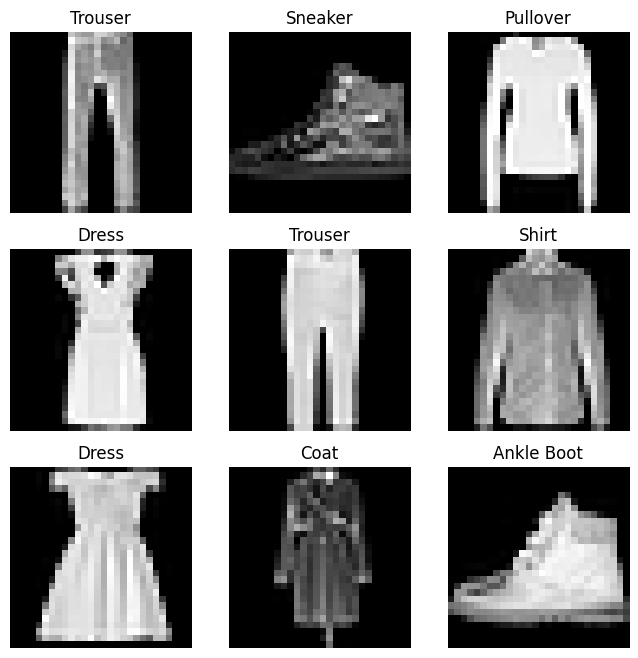

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. 
Take a look at this implementation; 
the FashionMNIST images are stored in a directory img_dir, 
and their labels are stored separately in a CSV file annotations_file.

In the next sections, we’ll break down what’s happening in each of these functions.
break down : (분석할 수 있도록) 나누어지다
각 함수에서 어떤 일이 일어나는지 나누어서 분석하겠다는 뜻
이외에 고장나다, 실패하다, 나빠지다, 감정을 주체하지 못하다 라는 뜻도 있음

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### __init__

The __init__ function is run once when instantiating the Dataset object. 
인스턴스 : 어떤 클래스에 속하는 각각의 객체
instantiating : 인스턴스화 : 클래스로부터 인스턴스를 생성하는것

We initialize the directory containing the images, the annotations file, 
and both transforms (covered in more detail in the next section).

The labels.csv file looks like:

tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9

In [6]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__

The __len__ function returns the number of samples in our dataset.

Example:

In [ ]:
def __len__(self):
    return len(self.img_labels)

### __getitem__

The __getitem__ function loads and returns a sample from the dataset at the given index / idx. 
Based on the index, it identifies the image’s location on disk, 
converts that to a tensor using read_image, 
retrieves the corresponding label from the csv data in self.img_labels, 
retrieves : 검색하다
calls the transform functions on them (if applicable), 
applicable : 해당되는, 적용되는
and returns the tensor image and corresponding label in a tuple.
corresponding : ~에 해당하는

In [7]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label


---

## Preparing your data for training with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. 
While training a model, we typically want to pass samples in “minibatches”, 
reshuffle the data at every epoch to reduce model overfitting, 
and use Python’s multiprocessing to speed up data retrieval.
retrieval : 검색

DataLoader is an iterable that abstracts this complexity for us in an easy API.
iterable : 1개의 데이터가 여러개의 구성요소를 가지는 것 ex. 리스트, 튜플, 딕셔너리 등
abstracts : 추상화

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. 
iterate : 반복하다
Each iteration below returns a batch of train_features and train_labels 
(containing batch_size=64 features and labels respectively). 
respectively : 각자, 각각
Because we specified shuffle=True, after we iterate over all batches the data is shuffled 
(for finer-grained control over the data loading order, take a look at Samplers).
specify : 명시하다

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


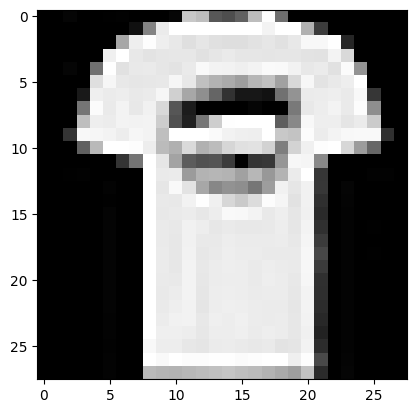

Label: 0


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")